In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
from scipy.stats import norm
import math
import random
import matplotlib.pyplot as plt
import pickle
from EM import EM
from plot import plot
from scipy import linalg
from numpy import ma

### Data Generation

In [128]:
class Model:
    # num_tseries is the number of time series generated by Model, each is time_length long
    # missing is the probability of an observation missing, default to zero 
    def __init__(self, time_length, num_tseries, missing=0):
        self.T = time_length
        self.num_tseries = num_tseries
        # model parameters
        self.A = np.array([[0]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([10])
        self.num_treatments = self.A.shape[1]
        self.num_chronic = self.b.shape[0]
        # noise are the variance, not standard deviation
        # noise for transition should be larger than noise for observation
        self.noise_0 = 10
        self.noise_1 = 1
        self.noise_2 = .01
        self.init_z = 6
        self.missing = missing
        # simulated data
        self.z = np.zeros((self.num_tseries, self.T))
        self.y = np.zeros((self.num_tseries, self.T))
        self.X = np.zeros((self.num_tseries, self.T, self.num_treatments))
        self.c = np.zeros((self.num_tseries, self.num_chronic))
        self.pi = np.zeros((self.num_tseries, self.T))
        
    def set_X(self, n):
        for t in range(self.T):
            self.X[n, t, :] = np.random.binomial(n=1, p=0.0, size=self.A.shape[1])# np.random.randint(2, size = self.num_treatments)

    def set_c(self, n):
        self.c[n, :] = np.random.binomial(n=1, p=0.5, size=self.num_chronic)#np.random.randint(2, size = self.num_chronic)
        
    def transition(self, prev):
        z = np.random.normal(prev, np.sqrt(self.noise_1), 1)
        return z

    def emission(self, z, n, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[n, t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c[n, :]) # total added effect
        prob = np.random.uniform(0, 1, 1)
        # to simulate time series we are dealing with, the first and last observations are not missing
        if prob < self.missing and t > 0 and t != self.T-1:
            y = np.nan
        else:
            mean = z + pi
            y = np.random.normal(mean, np.sqrt(self.noise_2), 1)
        return y, pi
    
    def pct_missing(self, n):
        pct = np.shape(np.where(np.isnan(self.y[n, :]))[0])[0]/self.T*100
        print('missing {}% of observations'.format(pct))
    
    # generate a single trajectory indexed n
    def gen_trajectory(self, n):
        self.set_X(n)
        self.set_c(n)
        self.z[n, 0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[n, 0], self.pi[n, 0] = self.emission(self.z[n, 0], n, 0)
        for t in range(1, self.T):
            self.z[n, t] = self.transition(self.z[n, t-1])
            self.y[n, t], self.pi[n, t] = self.emission(self.z[n, t], n, t)
    
    # plot the trajectory indexed n
    def plot_trajectory(self, n):
        times = list(range(self.T))
        fig = plt.figure()
        plt.plot(times, self.y[n, :], label = 'observed')
        plt.plot(times, self.z[n, :], label = 'counterfactual')
        for t in np.nonzero(self.X[n, :, :])[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        fig.set_figheight(8)
        fig.set_figwidth(15)
        plt.show()
    
    # generate and plot multiple trajectories 
    def run_simulation(self):
        np.random.seed(0)
        for n in range(self.num_tseries):
            self.gen_trajectory(n)
            #self.plot_trajectory(n)
            #self.pct_missing(n)

In [129]:
%%capture
model = Model(10, 50, 0.0)
model.run_simulation()

In [112]:
%%time
em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False, init_given=True, init_A=np.zeros_like(model.A), init_b=np.full_like(model.b, 9.0, dtype=np.float), init_0=.01, init_1=1, init_2=.01, init_state=6)#, X_prev_given=True, X_prev=X_prev)
num_iter = em.run_EM(10000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
50 iterations before params converge
CPU times: user 2.65 s, sys: 20.2 ms, total: 2.67 s
Wall time: 2.64 s


In [113]:
print('initial state variance initialization: {}'.format(round(em.init_0, 5)))
print('chronic initialization: {}'.format(np.round(em.init_b, 5)))
print('estimated initial state variance: {}'.format(round(em.sigma_0, 5)))
print('estimated chronic: {}'.format(np.round(em.b, 5)))

initial state variance initialization: 0.01
chronic initialization: [9.]
estimated initial state variance: 4.92079
estimated chronic: [9.17377]


In [140]:
%%time
initial_b = [-5, -3, 0, 3, 5, 7, 9, 11, 13, 15, 19]
initial_sigma_0 = [.001]
results = []
for sigma in initial_sigma_0:
    for b in initial_b:
        em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False, init_given=True, init_A=np.zeros_like(model.A), init_b=np.full_like(model.b, b, dtype=np.float), init_0=sigma, init_1=1, init_2=.01, init_state=6)#, X_prev_given=True, X_prev=X_prev)
        num_iter = em.run_EM(20000)
        results.append([em.init_0, em.init_b, em.sigma_0, em.b])

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

iteration 595
iteration 596
iteration 597
iteration 598
iteration 599
iteration 600
iteration 601
iteration 602
iteration 603
iteration 604
iteration 605
iteration 606
iteration 607
iteration 608
iteration 609
iteration 610
iteration 611
iteration 612
iteration 613
iteration 614
iteration 615
iteration 616
iteration 617
iteration 618
iteration 619
iteration 620
iteration 621
iteration 622
iteration 623
iteration 624
iteration 625
iteration 626
iteration 627
iteration 628
iteration 629
iteration 630
iteration 631
iteration 632
iteration 633
iteration 634
iteration 635
iteration 636
iteration 637
iteration 638
iteration 639
iteration 640
iteration 641
iteration 642
iteration 643
iteration 644
iteration 645
iteration 646
iteration 647
iteration 648
iteration 649
iteration 650
iteration 651
iteration 652
iteration 653
iteration 654
iteration 655
iteration 656
iteration 657
iteration 658
iteration 659
iteration 660
iteration 661
iteration 662
iteration 663
iteration 664
iteration 665
iterat

iteration 1171
iteration 1172
iteration 1173
iteration 1174
iteration 1175
iteration 1176
iteration 1177
iteration 1178
iteration 1179
iteration 1180
iteration 1181
iteration 1182
iteration 1183
iteration 1184
iteration 1185
iteration 1186
iteration 1187
iteration 1188
iteration 1189
iteration 1190
iteration 1191
iteration 1192
iteration 1193
iteration 1194
iteration 1195
iteration 1196
iteration 1197
iteration 1198
iteration 1199
iteration 1200
iteration 1201
iteration 1202
iteration 1203
iteration 1204
iteration 1205
iteration 1206
iteration 1207
iteration 1208
iteration 1209
iteration 1210
iteration 1211
iteration 1212
iteration 1213
iteration 1214
iteration 1215
iteration 1216
iteration 1217
iteration 1218
iteration 1219
iteration 1220
iteration 1221
iteration 1222
iteration 1223
iteration 1224
iteration 1225
iteration 1226
iteration 1227
iteration 1228
iteration 1229
iteration 1230
iteration 1231
iteration 1232
iteration 1233
iteration 1234
iteration 1235
iteration 1236
iteration 

iteration 1719
iteration 1720
iteration 1721
iteration 1722
iteration 1723
iteration 1724
iteration 1725
iteration 1726
iteration 1727
iteration 1728
iteration 1729
iteration 1730
iteration 1731
iteration 1732
iteration 1733
iteration 1734
iteration 1735
iteration 1736
iteration 1737
iteration 1738
iteration 1739
iteration 1740
iteration 1741
iteration 1742
iteration 1743
iteration 1744
iteration 1745
iteration 1746
iteration 1747
iteration 1748
iteration 1749
iteration 1750
iteration 1751
iteration 1752
iteration 1753
iteration 1754
iteration 1755
iteration 1756
iteration 1757
iteration 1758
iteration 1759
iteration 1760
iteration 1761
iteration 1762
iteration 1763
iteration 1764
iteration 1765
iteration 1766
iteration 1767
iteration 1768
iteration 1769
iteration 1770
iteration 1771
iteration 1772
iteration 1773
iteration 1774
iteration 1775
iteration 1776
iteration 1777
iteration 1778
iteration 1779
iteration 1780
iteration 1781
iteration 1782
iteration 1783
iteration 1784
iteration 

iteration 2268
iteration 2269
iteration 2270
iteration 2271
iteration 2272
iteration 2273
iteration 2274
iteration 2275
iteration 2276
iteration 2277
iteration 2278
iteration 2279
iteration 2280
iteration 2281
iteration 2282
iteration 2283
iteration 2284
iteration 2285
iteration 2286
iteration 2287
iteration 2288
iteration 2289
iteration 2290
iteration 2291
iteration 2292
iteration 2293
iteration 2294
iteration 2295
iteration 2296
iteration 2297
iteration 2298
iteration 2299
iteration 2300
iteration 2301
iteration 2302
iteration 2303
iteration 2304
iteration 2305
iteration 2306
iteration 2307
iteration 2308
iteration 2309
iteration 2310
iteration 2311
iteration 2312
iteration 2313
iteration 2314
iteration 2315
iteration 2316
iteration 2317
iteration 2318
iteration 2319
iteration 2320
iteration 2321
iteration 2322
iteration 2323
iteration 2324
iteration 2325
iteration 2326
iteration 2327
iteration 2328
iteration 2329
iteration 2330
iteration 2331
iteration 2332
iteration 2333
iteration 

iteration 2816
iteration 2817
iteration 2818
iteration 2819
iteration 2820
iteration 2821
iteration 2822
iteration 2823
iteration 2824
iteration 2825
iteration 2826
iteration 2827
iteration 2828
iteration 2829
iteration 2830
iteration 2831
iteration 2832
iteration 2833
iteration 2834
iteration 2835
iteration 2836
iteration 2837
iteration 2838
iteration 2839
iteration 2840
iteration 2841
iteration 2842
iteration 2843
iteration 2844
iteration 2845
iteration 2846
iteration 2847
iteration 2848
iteration 2849
iteration 2850
iteration 2851
iteration 2852
iteration 2853
iteration 2854
iteration 2855
iteration 2856
iteration 2857
iteration 2858
iteration 2859
iteration 2860
iteration 2861
iteration 2862
iteration 2863
iteration 2864
iteration 2865
iteration 2866
iteration 2867
iteration 2868
iteration 2869
iteration 2870
iteration 2871
iteration 2872
iteration 2873
iteration 2874
iteration 2875
iteration 2876
iteration 2877
iteration 2878
iteration 2879
iteration 2880
iteration 2881
iteration 

iteration 3364
iteration 3365
iteration 3366
iteration 3367
iteration 3368
iteration 3369
iteration 3370
iteration 3371
iteration 3372
iteration 3373
iteration 3374
iteration 3375
iteration 3376
iteration 3377
iteration 3378
iteration 3379
iteration 3380
iteration 3381
iteration 3382
iteration 3383
iteration 3384
iteration 3385
iteration 3386
iteration 3387
iteration 3388
iteration 3389
iteration 3390
iteration 3391
iteration 3392
iteration 3393
iteration 3394
iteration 3395
iteration 3396
iteration 3397
iteration 3398
iteration 3399
iteration 3400
iteration 3401
iteration 3402
iteration 3403
iteration 3404
iteration 3405
iteration 3406
iteration 3407
iteration 3408
iteration 3409
iteration 3410
iteration 3411
iteration 3412
iteration 3413
iteration 3414
iteration 3415
iteration 3416
iteration 3417
iteration 3418
iteration 3419
iteration 3420
iteration 3421
iteration 3422
iteration 3423
iteration 3424
iteration 3425
iteration 3426
iteration 3427
iteration 3428
iteration 3429
iteration 

iteration 3912
iteration 3913
iteration 3914
iteration 3915
iteration 3916
iteration 3917
iteration 3918
iteration 3919
iteration 3920
iteration 3921
iteration 3922
iteration 3923
iteration 3924
iteration 3925
iteration 3926
iteration 3927
iteration 3928
iteration 3929
iteration 3930
iteration 3931
iteration 3932
iteration 3933
iteration 3934
iteration 3935
iteration 3936
iteration 3937
iteration 3938
iteration 3939
iteration 3940
iteration 3941
iteration 3942
iteration 3943
iteration 3944
iteration 3945
iteration 3946
iteration 3947
iteration 3948
iteration 3949
iteration 3950
iteration 3951
iteration 3952
iteration 3953
iteration 3954
iteration 3955
iteration 3956
iteration 3957
iteration 3958
iteration 3959
iteration 3960
iteration 3961
iteration 3962
iteration 3963
iteration 3964
iteration 3965
iteration 3966
iteration 3967
iteration 3968
iteration 3969
iteration 3970
iteration 3971
iteration 3972
iteration 3973
iteration 3974
iteration 3975
iteration 3976
iteration 3977
iteration 

iteration 4460
iteration 4461
iteration 4462
iteration 4463
iteration 4464
iteration 4465
iteration 4466
iteration 4467
iteration 4468
iteration 4469
iteration 4470
iteration 4471
iteration 4472
iteration 4473
iteration 4474
iteration 4475
iteration 4476
iteration 4477
iteration 4478
iteration 4479
iteration 4480
iteration 4481
iteration 4482
iteration 4483
iteration 4484
iteration 4485
iteration 4486
iteration 4487
iteration 4488
iteration 4489
iteration 4490
iteration 4491
iteration 4492
iteration 4493
iteration 4494
iteration 4495
iteration 4496
iteration 4497
iteration 4498
iteration 4499
iteration 4500
iteration 4501
iteration 4502
iteration 4503
iteration 4504
iteration 4505
iteration 4506
iteration 4507
iteration 4508
iteration 4509
iteration 4510
iteration 4511
iteration 4512
iteration 4513
iteration 4514
iteration 4515
iteration 4516
iteration 4517
iteration 4518
iteration 4519
iteration 4520
iteration 4521
iteration 4522
iteration 4523
iteration 4524
iteration 4525
iteration 

iteration 5008
iteration 5009
iteration 5010
iteration 5011
iteration 5012
iteration 5013
iteration 5014
iteration 5015
iteration 5016
iteration 5017
iteration 5018
iteration 5019
iteration 5020
iteration 5021
iteration 5022
iteration 5023
iteration 5024
iteration 5025
iteration 5026
iteration 5027
iteration 5028
iteration 5029
iteration 5030
iteration 5031
iteration 5032
iteration 5033
iteration 5034
iteration 5035
iteration 5036
iteration 5037
iteration 5038
iteration 5039
iteration 5040
iteration 5041
iteration 5042
iteration 5043
iteration 5044
iteration 5045
iteration 5046
iteration 5047
iteration 5048
iteration 5049
iteration 5050
iteration 5051
iteration 5052
iteration 5053
iteration 5054
iteration 5055
iteration 5056
iteration 5057
iteration 5058
iteration 5059
iteration 5060
iteration 5061
iteration 5062
iteration 5063
iteration 5064
iteration 5065
iteration 5066
iteration 5067
iteration 5068
iteration 5069
iteration 5070
iteration 5071
iteration 5072
iteration 5073
iteration 

iteration 5556
iteration 5557
iteration 5558
iteration 5559
iteration 5560
iteration 5561
iteration 5562
iteration 5563
iteration 5564
iteration 5565
iteration 5566
iteration 5567
iteration 5568
iteration 5569
iteration 5570
iteration 5571
iteration 5572
iteration 5573
iteration 5574
iteration 5575
iteration 5576
iteration 5577
iteration 5578
iteration 5579
iteration 5580
iteration 5581
iteration 5582
iteration 5583
iteration 5584
iteration 5585
iteration 5586
iteration 5587
iteration 5588
iteration 5589
iteration 5590
iteration 5591
iteration 5592
iteration 5593
iteration 5594
iteration 5595
iteration 5596
iteration 5597
iteration 5598
iteration 5599
iteration 5600
iteration 5601
iteration 5602
iteration 5603
iteration 5604
iteration 5605
iteration 5606
iteration 5607
iteration 5608
iteration 5609
iteration 5610
iteration 5611
iteration 5612
iteration 5613
iteration 5614
iteration 5615
iteration 5616
iteration 5617
iteration 5618
iteration 5619
iteration 5620
iteration 5621
iteration 

iteration 6104
iteration 6105
iteration 6106
iteration 6107
iteration 6108
iteration 6109
iteration 6110
iteration 6111
iteration 6112
iteration 6113
iteration 6114
iteration 6115
iteration 6116
iteration 6117
iteration 6118
iteration 6119
iteration 6120
iteration 6121
iteration 6122
iteration 6123
iteration 6124
iteration 6125
iteration 6126
iteration 6127
iteration 6128
iteration 6129
iteration 6130
iteration 6131
iteration 6132
iteration 6133
iteration 6134
iteration 6135
iteration 6136
iteration 6137
iteration 6138
iteration 6139
iteration 6140
iteration 6141
iteration 6142
iteration 6143
iteration 6144
iteration 6145
iteration 6146
iteration 6147
iteration 6148
iteration 6149
iteration 6150
iteration 6151
iteration 6152
iteration 6153
iteration 6154
iteration 6155
iteration 6156
iteration 6157
iteration 6158
iteration 6159
iteration 6160
iteration 6161
iteration 6162
iteration 6163
iteration 6164
iteration 6165
iteration 6166
iteration 6167
iteration 6168
iteration 6169
iteration 

iteration 6652
iteration 6653
iteration 6654
iteration 6655
iteration 6656
iteration 6657
iteration 6658
iteration 6659
iteration 6660
iteration 6661
iteration 6662
iteration 6663
iteration 6664
iteration 6665
iteration 6666
iteration 6667
iteration 6668
iteration 6669
iteration 6670
iteration 6671
iteration 6672
iteration 6673
iteration 6674
iteration 6675
iteration 6676
iteration 6677
iteration 6678
iteration 6679
iteration 6680
iteration 6681
iteration 6682
iteration 6683
iteration 6684
iteration 6685
iteration 6686
iteration 6687
iteration 6688
iteration 6689
iteration 6690
iteration 6691
iteration 6692
iteration 6693
iteration 6694
iteration 6695
iteration 6696
iteration 6697
iteration 6698
iteration 6699
iteration 6700
iteration 6701
iteration 6702
iteration 6703
iteration 6704
iteration 6705
iteration 6706
iteration 6707
iteration 6708
iteration 6709
iteration 6710
iteration 6711
iteration 6712
iteration 6713
iteration 6714
iteration 6715
iteration 6716
iteration 6717
iteration 

iteration 7200
iteration 7201
iteration 7202
iteration 7203
iteration 7204
iteration 7205
iteration 7206
iteration 7207
iteration 7208
iteration 7209
iteration 7210
iteration 7211
iteration 7212
iteration 7213
iteration 7214
iteration 7215
iteration 7216
iteration 7217
iteration 7218
iteration 7219
iteration 7220
iteration 7221
iteration 7222
iteration 7223
iteration 7224
iteration 7225
iteration 7226
iteration 7227
iteration 7228
iteration 7229
iteration 7230
iteration 7231
iteration 7232
iteration 7233
iteration 7234
iteration 7235
iteration 7236
iteration 7237
iteration 7238
iteration 7239
iteration 7240
iteration 7241
iteration 7242
iteration 7243
iteration 7244
iteration 7245
iteration 7246
iteration 7247
iteration 7248
iteration 7249
iteration 7250
iteration 7251
iteration 7252
iteration 7253
iteration 7254
iteration 7255
iteration 7256
iteration 7257
iteration 7258
iteration 7259
iteration 7260
iteration 7261
iteration 7262
iteration 7263
iteration 7264
iteration 7265
iteration 

iteration 7748
iteration 7749
iteration 7750
iteration 7751
iteration 7752
iteration 7753
iteration 7754
iteration 7755
iteration 7756
iteration 7757
iteration 7758
iteration 7759
iteration 7760
iteration 7761
iteration 7762
iteration 7763
iteration 7764
iteration 7765
iteration 7766
iteration 7767
iteration 7768
iteration 7769
iteration 7770
iteration 7771
iteration 7772
iteration 7773
iteration 7774
iteration 7775
iteration 7776
iteration 7777
iteration 7778
iteration 7779
iteration 7780
iteration 7781
iteration 7782
iteration 7783
iteration 7784
iteration 7785
iteration 7786
iteration 7787
iteration 7788
iteration 7789
iteration 7790
iteration 7791
iteration 7792
iteration 7793
iteration 7794
iteration 7795
iteration 7796
iteration 7797
iteration 7798
iteration 7799
iteration 7800
iteration 7801
iteration 7802
iteration 7803
iteration 7804
iteration 7805
iteration 7806
iteration 7807
iteration 7808
iteration 7809
iteration 7810
iteration 7811
iteration 7812
iteration 7813
iteration 

iteration 8295
iteration 8296
iteration 8297
iteration 8298
iteration 8299
iteration 8300
iteration 8301
iteration 8302
iteration 8303
iteration 8304
iteration 8305
iteration 8306
iteration 8307
iteration 8308
iteration 8309
iteration 8310
iteration 8311
iteration 8312
iteration 8313
iteration 8314
iteration 8315
iteration 8316
iteration 8317
iteration 8318
iteration 8319
iteration 8320
iteration 8321
iteration 8322
iteration 8323
iteration 8324
iteration 8325
iteration 8326
iteration 8327
iteration 8328
iteration 8329
iteration 8330
iteration 8331
iteration 8332
iteration 8333
iteration 8334
iteration 8335
iteration 8336
iteration 8337
iteration 8338
iteration 8339
iteration 8340
iteration 8341
iteration 8342
iteration 8343
iteration 8344
iteration 8345
iteration 8346
iteration 8347
iteration 8348
iteration 8349
iteration 8350
iteration 8351
iteration 8352
iteration 8353
iteration 8354
iteration 8355
iteration 8356
iteration 8357
iteration 8358
iteration 8359
iteration 8360
iteration 

iteration 301
iteration 302
iteration 303
iteration 304
iteration 305
iteration 306
iteration 307
iteration 308
iteration 309
iteration 310
iteration 311
iteration 312
iteration 313
iteration 314
iteration 315
iteration 316
iteration 317
iteration 318
iteration 319
iteration 320
iteration 321
iteration 322
iteration 323
iteration 324
iteration 325
iteration 326
iteration 327
iteration 328
iteration 329
iteration 330
iteration 331
iteration 332
iteration 333
iteration 334
iteration 335
iteration 336
iteration 337
iteration 338
iteration 339
iteration 340
iteration 341
iteration 342
iteration 343
iteration 344
iteration 345
iteration 346
iteration 347
iteration 348
iteration 349
iteration 350
iteration 351
iteration 352
iteration 353
iteration 354
iteration 355
iteration 356
iteration 357
iteration 358
iteration 359
iteration 360
iteration 361
iteration 362
iteration 363
iteration 364
iteration 365
iteration 366
iteration 367
iteration 368
iteration 369
iteration 370
iteration 371
iterat

iteration 889
iteration 890
iteration 891
iteration 892
iteration 893
iteration 894
iteration 895
iteration 896
iteration 897
iteration 898
iteration 899
iteration 900
iteration 901
iteration 902
iteration 903
iteration 904
iteration 905
iteration 906
iteration 907
iteration 908
iteration 909
iteration 910
iteration 911
iteration 912
iteration 913
iteration 914
iteration 915
iteration 916
iteration 917
iteration 918
iteration 919
iteration 920
iteration 921
iteration 922
iteration 923
iteration 924
iteration 925
iteration 926
iteration 927
iteration 928
iteration 929
iteration 930
iteration 931
iteration 932
iteration 933
iteration 934
iteration 935
iteration 936
iteration 937
iteration 938
iteration 939
iteration 940
iteration 941
iteration 942
iteration 943
iteration 944
iteration 945
iteration 946
iteration 947
iteration 948
iteration 949
iteration 950
iteration 951
iteration 952
iteration 953
iteration 954
iteration 955
iteration 956
iteration 957
iteration 958
iteration 959
iterat

iteration 1445
iteration 1446
iteration 1447
iteration 1448
iteration 1449
iteration 1450
iteration 1451
iteration 1452
iteration 1453
iteration 1454
iteration 1455
iteration 1456
iteration 1457
iteration 1458
iteration 1459
iteration 1460
iteration 1461
iteration 1462
iteration 1463
iteration 1464
iteration 1465
iteration 1466
iteration 1467
iteration 1468
iteration 1469
iteration 1470
iteration 1471
iteration 1472
iteration 1473
iteration 1474
iteration 1475
iteration 1476
iteration 1477
iteration 1478
iteration 1479
iteration 1480
iteration 1481
iteration 1482
iteration 1483
iteration 1484
iteration 1485
iteration 1486
iteration 1487
iteration 1488
iteration 1489
iteration 1490
iteration 1491
iteration 1492
iteration 1493
iteration 1494
iteration 1495
iteration 1496
iteration 1497
iteration 1498
iteration 1499
iteration 1500
iteration 1501
iteration 1502
iteration 1503
iteration 1504
iteration 1505
iteration 1506
iteration 1507
iteration 1508
iteration 1509
iteration 1510
iteration 

iteration 1993
iteration 1994
iteration 1995
iteration 1996
iteration 1997
iteration 1998
iteration 1999
iteration 2000
iteration 2001
iteration 2002
iteration 2003
iteration 2004
iteration 2005
iteration 2006
iteration 2007
iteration 2008
iteration 2009
iteration 2010
iteration 2011
iteration 2012
iteration 2013
iteration 2014
iteration 2015
iteration 2016
iteration 2017
iteration 2018
iteration 2019
iteration 2020
iteration 2021
iteration 2022
iteration 2023
iteration 2024
iteration 2025
iteration 2026
iteration 2027
iteration 2028
iteration 2029
iteration 2030
iteration 2031
iteration 2032
iteration 2033
iteration 2034
iteration 2035
iteration 2036
iteration 2037
iteration 2038
iteration 2039
iteration 2040
iteration 2041
iteration 2042
iteration 2043
iteration 2044
iteration 2045
iteration 2046
iteration 2047
iteration 2048
iteration 2049
iteration 2050
iteration 2051
iteration 2052
iteration 2053
iteration 2054
iteration 2055
iteration 2056
iteration 2057
iteration 2058
iteration 

iteration 2541
iteration 2542
iteration 2543
iteration 2544
iteration 2545
iteration 2546
iteration 2547
iteration 2548
iteration 2549
iteration 2550
iteration 2551
iteration 2552
iteration 2553
iteration 2554
iteration 2555
iteration 2556
iteration 2557
iteration 2558
iteration 2559
iteration 2560
iteration 2561
iteration 2562
iteration 2563
iteration 2564
iteration 2565
iteration 2566
iteration 2567
iteration 2568
iteration 2569
iteration 2570
iteration 2571
iteration 2572
iteration 2573
iteration 2574
iteration 2575
iteration 2576
iteration 2577
iteration 2578
iteration 2579
iteration 2580
iteration 2581
iteration 2582
iteration 2583
iteration 2584
iteration 2585
iteration 2586
iteration 2587
iteration 2588
iteration 2589
iteration 2590
iteration 2591
iteration 2592
iteration 2593
iteration 2594
iteration 2595
iteration 2596
iteration 2597
iteration 2598
iteration 2599
iteration 2600
iteration 2601
iteration 2602
iteration 2603
iteration 2604
iteration 2605
iteration 2606
iteration 

iteration 3089
iteration 3090
iteration 3091
iteration 3092
iteration 3093
iteration 3094
iteration 3095
iteration 3096
iteration 3097
iteration 3098
iteration 3099
iteration 3100
iteration 3101
iteration 3102
iteration 3103
iteration 3104
iteration 3105
iteration 3106
iteration 3107
iteration 3108
iteration 3109
iteration 3110
iteration 3111
iteration 3112
iteration 3113
iteration 3114
iteration 3115
iteration 3116
iteration 3117
iteration 3118
iteration 3119
iteration 3120
iteration 3121
iteration 3122
iteration 3123
iteration 3124
iteration 3125
iteration 3126
iteration 3127
iteration 3128
iteration 3129
iteration 3130
iteration 3131
iteration 3132
iteration 3133
iteration 3134
iteration 3135
iteration 3136
iteration 3137
iteration 3138
iteration 3139
iteration 3140
iteration 3141
iteration 3142
iteration 3143
iteration 3144
iteration 3145
iteration 3146
iteration 3147
iteration 3148
iteration 3149
iteration 3150
iteration 3151
iteration 3152
iteration 3153
iteration 3154
iteration 

iteration 3638
iteration 3639
iteration 3640
iteration 3641
iteration 3642
iteration 3643
iteration 3644
iteration 3645
iteration 3646
iteration 3647
iteration 3648
iteration 3649
iteration 3650
iteration 3651
iteration 3652
iteration 3653
iteration 3654
iteration 3655
iteration 3656
iteration 3657
iteration 3658
iteration 3659
iteration 3660
iteration 3661
iteration 3662
iteration 3663
iteration 3664
iteration 3665
iteration 3666
iteration 3667
iteration 3668
iteration 3669
iteration 3670
iteration 3671
iteration 3672
iteration 3673
iteration 3674
iteration 3675
iteration 3676
iteration 3677
iteration 3678
iteration 3679
iteration 3680
iteration 3681
iteration 3682
iteration 3683
iteration 3684
iteration 3685
iteration 3686
iteration 3687
iteration 3688
iteration 3689
iteration 3690
iteration 3691
iteration 3692
iteration 3693
iteration 3694
iteration 3695
iteration 3696
iteration 3697
iteration 3698
iteration 3699
iteration 3700
iteration 3701
iteration 3702
iteration 3703
iteration 

iteration 4186
iteration 4187
iteration 4188
iteration 4189
iteration 4190
iteration 4191
iteration 4192
iteration 4193
iteration 4194
iteration 4195
iteration 4196
iteration 4197
iteration 4198
iteration 4199
iteration 4200
iteration 4201
iteration 4202
iteration 4203
iteration 4204
iteration 4205
iteration 4206
iteration 4207
iteration 4208
iteration 4209
iteration 4210
iteration 4211
iteration 4212
iteration 4213
iteration 4214
iteration 4215
iteration 4216
iteration 4217
iteration 4218
iteration 4219
iteration 4220
iteration 4221
iteration 4222
iteration 4223
iteration 4224
iteration 4225
iteration 4226
iteration 4227
iteration 4228
iteration 4229
iteration 4230
iteration 4231
iteration 4232
iteration 4233
iteration 4234
iteration 4235
iteration 4236
iteration 4237
iteration 4238
iteration 4239
iteration 4240
iteration 4241
iteration 4242
iteration 4243
iteration 4244
iteration 4245
iteration 4246
iteration 4247
iteration 4248
iteration 4249
iteration 4250
iteration 4251
iteration 

iteration 4734
iteration 4735
iteration 4736
iteration 4737
iteration 4738
iteration 4739
iteration 4740
iteration 4741
iteration 4742
iteration 4743
iteration 4744
iteration 4745
iteration 4746
iteration 4747
iteration 4748
iteration 4749
iteration 4750
iteration 4751
iteration 4752
iteration 4753
iteration 4754
iteration 4755
iteration 4756
iteration 4757
iteration 4758
iteration 4759
iteration 4760
iteration 4761
iteration 4762
iteration 4763
iteration 4764
iteration 4765
iteration 4766
iteration 4767
iteration 4768
iteration 4769
iteration 4770
iteration 4771
iteration 4772
iteration 4773
iteration 4774
iteration 4775
iteration 4776
iteration 4777
iteration 4778
iteration 4779
iteration 4780
iteration 4781
iteration 4782
iteration 4783
iteration 4784
iteration 4785
iteration 4786
iteration 4787
iteration 4788
iteration 4789
iteration 4790
iteration 4791
iteration 4792
iteration 4793
iteration 4794
iteration 4795
iteration 4796
iteration 4797
iteration 4798
iteration 4799
iteration 

iteration 5282
iteration 5283
iteration 5284
iteration 5285
iteration 5286
iteration 5287
iteration 5288
iteration 5289
iteration 5290
iteration 5291
iteration 5292
iteration 5293
iteration 5294
iteration 5295
iteration 5296
iteration 5297
iteration 5298
iteration 5299
iteration 5300
iteration 5301
iteration 5302
iteration 5303
iteration 5304
iteration 5305
iteration 5306
iteration 5307
iteration 5308
iteration 5309
iteration 5310
iteration 5311
iteration 5312
iteration 5313
iteration 5314
iteration 5315
iteration 5316
iteration 5317
iteration 5318
iteration 5319
iteration 5320
iteration 5321
iteration 5322
iteration 5323
iteration 5324
iteration 5325
iteration 5326
iteration 5327
iteration 5328
iteration 5329
iteration 5330
iteration 5331
iteration 5332
iteration 5333
iteration 5334
iteration 5335
iteration 5336
iteration 5337
iteration 5338
iteration 5339
iteration 5340
iteration 5341
iteration 5342
iteration 5343
iteration 5344
iteration 5345
iteration 5346
iteration 5347
iteration 

iteration 5830
iteration 5831
iteration 5832
iteration 5833
iteration 5834
iteration 5835
iteration 5836
iteration 5837
iteration 5838
iteration 5839
iteration 5840
iteration 5841
iteration 5842
iteration 5843
iteration 5844
iteration 5845
iteration 5846
iteration 5847
iteration 5848
iteration 5849
iteration 5850
iteration 5851
iteration 5852
iteration 5853
iteration 5854
iteration 5855
iteration 5856
iteration 5857
iteration 5858
iteration 5859
iteration 5860
iteration 5861
iteration 5862
iteration 5863
iteration 5864
iteration 5865
iteration 5866
iteration 5867
iteration 5868
iteration 5869
iteration 5870
iteration 5871
iteration 5872
iteration 5873
iteration 5874
iteration 5875
iteration 5876
iteration 5877
iteration 5878
iteration 5879
iteration 5880
iteration 5881
iteration 5882
iteration 5883
iteration 5884
iteration 5885
iteration 5886
iteration 5887
iteration 5888
iteration 5889
iteration 5890
iteration 5891
iteration 5892
iteration 5893
iteration 5894
iteration 5895
iteration 

iteration 6378
iteration 6379
iteration 6380
iteration 6381
iteration 6382
iteration 6383
iteration 6384
iteration 6385
iteration 6386
iteration 6387
iteration 6388
iteration 6389
iteration 6390
iteration 6391
iteration 6392
iteration 6393
iteration 6394
iteration 6395
iteration 6396
iteration 6397
iteration 6398
iteration 6399
iteration 6400
iteration 6401
iteration 6402
iteration 6403
iteration 6404
iteration 6405
iteration 6406
iteration 6407
iteration 6408
iteration 6409
iteration 6410
iteration 6411
iteration 6412
iteration 6413
iteration 6414
iteration 6415
iteration 6416
iteration 6417
iteration 6418
iteration 6419
iteration 6420
iteration 6421
iteration 6422
iteration 6423
iteration 6424
iteration 6425
iteration 6426
iteration 6427
iteration 6428
iteration 6429
iteration 6430
iteration 6431
iteration 6432
iteration 6433
iteration 6434
iteration 6435
iteration 6436
iteration 6437
iteration 6438
iteration 6439
iteration 6440
iteration 6441
iteration 6442
iteration 6443
iteration 

iteration 6926
iteration 6927
iteration 6928
iteration 6929
iteration 6930
iteration 6931
iteration 6932
iteration 6933
iteration 6934
iteration 6935
iteration 6936
iteration 6937
iteration 6938
iteration 6939
iteration 6940
iteration 6941
iteration 6942
iteration 6943
iteration 6944
iteration 6945
iteration 6946
iteration 6947
iteration 6948
iteration 6949
iteration 6950
iteration 6951
iteration 6952
iteration 6953
iteration 6954
iteration 6955
iteration 6956
iteration 6957
iteration 6958
iteration 6959
iteration 6960
iteration 6961
iteration 6962
iteration 6963
iteration 6964
iteration 6965
iteration 6966
iteration 6967
iteration 6968
iteration 6969
iteration 6970
iteration 6971
iteration 6972
iteration 6973
iteration 6974
iteration 6975
iteration 6976
iteration 6977
iteration 6978
6978 iterations before params converge
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iterat

iteration 536
iteration 537
iteration 538
iteration 539
iteration 540
iteration 541
iteration 542
iteration 543
iteration 544
iteration 545
iteration 546
iteration 547
iteration 548
iteration 549
iteration 550
iteration 551
iteration 552
iteration 553
iteration 554
iteration 555
iteration 556
iteration 557
iteration 558
iteration 559
iteration 560
iteration 561
iteration 562
iteration 563
iteration 564
iteration 565
iteration 566
iteration 567
iteration 568
iteration 569
iteration 570
iteration 571
iteration 572
iteration 573
iteration 574
iteration 575
iteration 576
iteration 577
iteration 578
iteration 579
iteration 580
iteration 581
iteration 582
iteration 583
iteration 584
iteration 585
iteration 586
iteration 587
iteration 588
iteration 589
iteration 590
iteration 591
iteration 592
iteration 593
iteration 594
iteration 595
iteration 596
iteration 597
iteration 598
iteration 599
iteration 600
iteration 601
iteration 602
iteration 603
iteration 604
iteration 605
iteration 606
iterat

iteration 1116
iteration 1117
iteration 1118
iteration 1119
iteration 1120
iteration 1121
iteration 1122
iteration 1123
iteration 1124
iteration 1125
iteration 1126
iteration 1127
iteration 1128
iteration 1129
iteration 1130
iteration 1131
iteration 1132
iteration 1133
iteration 1134
iteration 1135
iteration 1136
iteration 1137
iteration 1138
iteration 1139
iteration 1140
iteration 1141
iteration 1142
iteration 1143
iteration 1144
iteration 1145
iteration 1146
iteration 1147
iteration 1148
iteration 1149
iteration 1150
iteration 1151
iteration 1152
iteration 1153
iteration 1154
iteration 1155
iteration 1156
iteration 1157
iteration 1158
iteration 1159
iteration 1160
iteration 1161
iteration 1162
iteration 1163
iteration 1164
iteration 1165
iteration 1166
iteration 1167
iteration 1168
iteration 1169
iteration 1170
iteration 1171
iteration 1172
iteration 1173
iteration 1174
iteration 1175
iteration 1176
iteration 1177
iteration 1178
iteration 1179
iteration 1180
iteration 1181
iteration 

iteration 1665
iteration 1666
iteration 1667
iteration 1668
iteration 1669
iteration 1670
iteration 1671
iteration 1672
iteration 1673
iteration 1674
iteration 1675
iteration 1676
iteration 1677
iteration 1678
iteration 1679
iteration 1680
iteration 1681
iteration 1682
iteration 1683
iteration 1684
iteration 1685
iteration 1686
iteration 1687
iteration 1688
iteration 1689
iteration 1690
iteration 1691
iteration 1692
iteration 1693
iteration 1694
iteration 1695
iteration 1696
iteration 1697
iteration 1698
iteration 1699
iteration 1700
iteration 1701
iteration 1702
iteration 1703
iteration 1704
iteration 1705
iteration 1706
iteration 1707
iteration 1708
iteration 1709
iteration 1710
iteration 1711
iteration 1712
iteration 1713
iteration 1714
iteration 1715
iteration 1716
iteration 1717
iteration 1718
iteration 1719
iteration 1720
iteration 1721
iteration 1722
iteration 1723
iteration 1724
iteration 1725
iteration 1726
iteration 1727
iteration 1728
iteration 1729
iteration 1730
iteration 

iteration 2213
iteration 2214
iteration 2215
iteration 2216
iteration 2217
iteration 2218
iteration 2219
iteration 2220
iteration 2221
iteration 2222
iteration 2223
iteration 2224
iteration 2225
iteration 2226
iteration 2227
iteration 2228
iteration 2229
iteration 2230
iteration 2231
iteration 2232
iteration 2233
iteration 2234
iteration 2235
iteration 2236
iteration 2237
iteration 2238
iteration 2239
iteration 2240
iteration 2241
iteration 2242
iteration 2243
iteration 2244
iteration 2245
iteration 2246
iteration 2247
iteration 2248
iteration 2249
iteration 2250
iteration 2251
iteration 2252
iteration 2253
iteration 2254
iteration 2255
iteration 2256
iteration 2257
iteration 2258
iteration 2259
iteration 2260
iteration 2261
iteration 2262
iteration 2263
iteration 2264
iteration 2265
iteration 2266
iteration 2267
iteration 2268
iteration 2269
iteration 2270
iteration 2271
iteration 2272
iteration 2273
iteration 2274
iteration 2275
iteration 2276
iteration 2277
iteration 2278
iteration 

iteration 2763
iteration 2764
iteration 2765
iteration 2766
iteration 2767
iteration 2768
iteration 2769
iteration 2770
iteration 2771
iteration 2772
iteration 2773
iteration 2774
iteration 2775
iteration 2776
iteration 2777
iteration 2778
iteration 2779
iteration 2780
iteration 2781
iteration 2782
iteration 2783
iteration 2784
iteration 2785
iteration 2786
iteration 2787
iteration 2788
iteration 2789
iteration 2790
iteration 2791
iteration 2792
iteration 2793
iteration 2794
iteration 2795
iteration 2796
iteration 2797
iteration 2798
iteration 2799
iteration 2800
iteration 2801
iteration 2802
iteration 2803
iteration 2804
iteration 2805
iteration 2806
iteration 2807
iteration 2808
iteration 2809
iteration 2810
iteration 2811
iteration 2812
iteration 2813
iteration 2814
iteration 2815
iteration 2816
iteration 2817
iteration 2818
iteration 2819
iteration 2820
iteration 2821
iteration 2822
iteration 2823
iteration 2824
iteration 2825
iteration 2826
iteration 2827
iteration 2828
iteration 

iteration 3312
iteration 3313
iteration 3314
iteration 3315
iteration 3316
iteration 3317
iteration 3318
iteration 3319
iteration 3320
iteration 3321
iteration 3322
iteration 3323
iteration 3324
iteration 3325
iteration 3326
iteration 3327
iteration 3328
iteration 3329
iteration 3330
iteration 3331
iteration 3332
iteration 3333
iteration 3334
iteration 3335
iteration 3336
iteration 3337
iteration 3338
iteration 3339
iteration 3340
iteration 3341
iteration 3342
iteration 3343
iteration 3344
iteration 3345
iteration 3346
iteration 3347
iteration 3348
iteration 3349
iteration 3350
iteration 3351
iteration 3352
iteration 3353
iteration 3354
iteration 3355
iteration 3356
iteration 3357
iteration 3358
iteration 3359
iteration 3360
iteration 3361
iteration 3362
iteration 3363
iteration 3364
iteration 3365
iteration 3366
iteration 3367
iteration 3368
iteration 3369
iteration 3370
iteration 3371
iteration 3372
iteration 3373
iteration 3374
iteration 3375
iteration 3376
iteration 3377
iteration 

iteration 3862
iteration 3863
iteration 3864
iteration 3865
iteration 3866
iteration 3867
iteration 3868
iteration 3869
iteration 3870
iteration 3871
iteration 3872
iteration 3873
iteration 3874
iteration 3875
iteration 3876
iteration 3877
iteration 3878
iteration 3879
iteration 3880
iteration 3881
iteration 3882
iteration 3883
iteration 3884
iteration 3885
iteration 3886
iteration 3887
iteration 3888
iteration 3889
iteration 3890
iteration 3891
iteration 3892
iteration 3893
iteration 3894
iteration 3895
iteration 3896
iteration 3897
iteration 3898
iteration 3899
iteration 3900
iteration 3901
iteration 3902
iteration 3903
iteration 3904
iteration 3905
iteration 3906
iteration 3907
iteration 3908
iteration 3909
iteration 3910
iteration 3911
iteration 3912
iteration 3913
iteration 3914
iteration 3915
iteration 3916
iteration 3917
iteration 3918
iteration 3919
iteration 3920
iteration 3921
iteration 3922
iteration 3923
iteration 3924
iteration 3925
iteration 3926
iteration 3927
iteration 

iteration 4411
iteration 4412
iteration 4413
iteration 4414
iteration 4415
iteration 4416
iteration 4417
iteration 4418
iteration 4419
iteration 4420
iteration 4421
iteration 4422
iteration 4423
iteration 4424
iteration 4425
iteration 4426
iteration 4427
iteration 4428
iteration 4429
iteration 4430
iteration 4431
iteration 4432
iteration 4433
iteration 4434
iteration 4435
iteration 4436
iteration 4437
iteration 4438
iteration 4439
iteration 4440
iteration 4441
iteration 4442
iteration 4443
iteration 4444
iteration 4445
iteration 4446
iteration 4447
iteration 4448
iteration 4449
iteration 4450
iteration 4451
iteration 4452
iteration 4453
iteration 4454
iteration 4455
iteration 4456
iteration 4457
iteration 4458
iteration 4459
iteration 4460
iteration 4461
iteration 4462
iteration 4463
iteration 4464
iteration 4465
iteration 4466
iteration 4467
iteration 4468
iteration 4469
iteration 4470
iteration 4471
iteration 4472
iteration 4473
iteration 4474
iteration 4475
iteration 4476
iteration 

iteration 313
iteration 314
iteration 315
iteration 316
iteration 317
iteration 318
iteration 319
iteration 320
iteration 321
iteration 322
iteration 323
iteration 324
iteration 325
iteration 326
iteration 327
iteration 328
iteration 329
iteration 330
iteration 331
iteration 332
iteration 333
iteration 334
iteration 335
iteration 336
iteration 337
iteration 338
iteration 339
iteration 340
iteration 341
iteration 342
iteration 343
iteration 344
iteration 345
iteration 346
iteration 347
iteration 348
iteration 349
iteration 350
iteration 351
iteration 352
iteration 353
iteration 354
iteration 355
iteration 356
iteration 357
iteration 358
iteration 359
iteration 360
iteration 361
iteration 362
iteration 363
iteration 364
iteration 365
iteration 366
iteration 367
iteration 368
iteration 369
iteration 370
iteration 371
iteration 372
iteration 373
iteration 374
iteration 375
iteration 376
iteration 377
iteration 378
iteration 379
iteration 380
iteration 381
iteration 382
iteration 383
iterat

iteration 902
iteration 903
iteration 904
iteration 905
iteration 906
iteration 907
iteration 908
iteration 909
iteration 910
iteration 911
iteration 912
iteration 913
iteration 914
iteration 915
iteration 916
iteration 917
iteration 918
iteration 919
iteration 920
iteration 921
iteration 922
iteration 923
iteration 924
iteration 925
iteration 926
iteration 927
iteration 928
iteration 929
iteration 930
iteration 931
iteration 932
iteration 933
iteration 934
iteration 935
iteration 936
iteration 937
iteration 938
iteration 939
iteration 940
iteration 941
iteration 942
iteration 943
iteration 944
iteration 945
iteration 946
iteration 947
iteration 948
iteration 949
iteration 950
iteration 951
iteration 952
iteration 953
iteration 954
iteration 955
iteration 956
iteration 957
iteration 958
iteration 959
iteration 960
iteration 961
iteration 962
iteration 963
iteration 964
iteration 965
iteration 966
iteration 967
iteration 968
iteration 969
iteration 970
iteration 971
iteration 972
iterat

iteration 1458
iteration 1459
iteration 1460
iteration 1461
iteration 1462
iteration 1463
iteration 1464
iteration 1465
iteration 1466
iteration 1467
iteration 1468
iteration 1469
iteration 1470
iteration 1471
iteration 1472
iteration 1473
iteration 1474
iteration 1475
iteration 1476
iteration 1477
iteration 1478
iteration 1479
iteration 1480
iteration 1481
iteration 1482
iteration 1483
iteration 1484
iteration 1485
iteration 1486
iteration 1487
iteration 1488
iteration 1489
iteration 1490
iteration 1491
iteration 1492
iteration 1493
iteration 1494
iteration 1495
iteration 1496
iteration 1497
iteration 1498
iteration 1499
iteration 1500
iteration 1501
iteration 1502
iteration 1503
iteration 1504
iteration 1505
iteration 1506
iteration 1507
iteration 1508
iteration 1509
iteration 1510
iteration 1511
iteration 1512
iteration 1513
iteration 1514
iteration 1515
iteration 1516
iteration 1517
iteration 1518
iteration 1519
iteration 1520
iteration 1521
iteration 1522
iteration 1523
iteration 

iteration 2008
iteration 2009
iteration 2010
iteration 2011
iteration 2012
iteration 2013
iteration 2014
iteration 2015
iteration 2016
iteration 2017
iteration 2018
iteration 2019
iteration 2020
iteration 2021
iteration 2022
iteration 2023
iteration 2024
iteration 2025
iteration 2026
iteration 2027
iteration 2028
iteration 2029
iteration 2030
iteration 2031
iteration 2032
iteration 2033
iteration 2034
iteration 2035
iteration 2036
iteration 2037
iteration 2038
iteration 2039
iteration 2040
iteration 2041
iteration 2042
iteration 2043
iteration 2044
iteration 2045
iteration 2046
iteration 2047
iteration 2048
iteration 2049
iteration 2050
iteration 2051
iteration 2052
iteration 2053
iteration 2054
iteration 2055
iteration 2056
iteration 2057
iteration 2058
iteration 2059
iteration 2060
iteration 2061
iteration 2062
iteration 2063
iteration 2064
iteration 2065
iteration 2066
iteration 2067
iteration 2068
iteration 2069
iteration 2070
iteration 2071
iteration 2072
iteration 2073
iteration 

iteration 186
iteration 187
iteration 188
iteration 189
iteration 190
iteration 191
iteration 192
iteration 193
iteration 194
iteration 195
iteration 196
iteration 197
iteration 198
iteration 199
iteration 200
iteration 201
iteration 202
iteration 203
iteration 204
iteration 205
iteration 206
iteration 207
iteration 208
iteration 209
iteration 210
iteration 211
iteration 212
iteration 213
iteration 214
iteration 215
iteration 216
iteration 217
iteration 218
iteration 219
iteration 220
iteration 221
iteration 222
iteration 223
iteration 224
iteration 225
iteration 226
iteration 227
iteration 228
iteration 229
iteration 230
iteration 231
iteration 232
iteration 233
iteration 234
iteration 235
iteration 236
iteration 237
iteration 238
iteration 239
iteration 240
iteration 241
iteration 242
iteration 243
iteration 244
iteration 245
iteration 246
iteration 247
iteration 248
iteration 249
iteration 250
iteration 251
iteration 252
iteration 253
iteration 254
iteration 255
iteration 256
iterat

iteration 773
iteration 774
iteration 775
iteration 776
iteration 777
iteration 778
iteration 779
iteration 780
iteration 781
iteration 782
iteration 783
iteration 784
iteration 785
iteration 786
iteration 787
iteration 788
iteration 789
iteration 790
iteration 791
iteration 792
iteration 793
iteration 794
iteration 795
iteration 796
iteration 797
iteration 798
iteration 799
iteration 800
iteration 801
iteration 802
iteration 803
iteration 804
iteration 805
iteration 806
iteration 807
iteration 808
iteration 809
iteration 810
iteration 811
iteration 812
iteration 813
iteration 814
iteration 815
iteration 816
iteration 817
iteration 818
iteration 819
iteration 820
iteration 821
iteration 822
iteration 823
iteration 824
iteration 825
iteration 826
iteration 827
iteration 828
iteration 829
iteration 830
iteration 831
iteration 832
iteration 833
iteration 834
iteration 835
iteration 836
iteration 837
iteration 838
iteration 839
iteration 840
iteration 841
iteration 842
iteration 843
iterat

iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
64 iterations before params converge
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 

iteration 516
iteration 517
iteration 518
iteration 519
iteration 520
iteration 521
iteration 522
iteration 523
iteration 524
iteration 525
iteration 526
iteration 527
iteration 528
iteration 529
iteration 530
iteration 531
iteration 532
iteration 533
iteration 534
iteration 535
iteration 536
iteration 537
iteration 538
iteration 539
iteration 540
iteration 541
iteration 542
iteration 543
iteration 544
iteration 545
iteration 546
iteration 547
iteration 548
iteration 549
iteration 550
iteration 551
iteration 552
iteration 553
iteration 554
iteration 555
iteration 556
iteration 557
iteration 558
iteration 559
iteration 560
iteration 561
iteration 562
iteration 563
iteration 564
iteration 565
iteration 566
iteration 567
iteration 568
iteration 569
iteration 570
iteration 571
iteration 572
iteration 573
iteration 574
iteration 575
iteration 576
iteration 577
iteration 578
iteration 579
iteration 580
iteration 581
iteration 582
iteration 583
iteration 584
iteration 585
iteration 586
iterat

In [141]:
results

[[0.001, array([-5.]), 11.709242048807402, array([8.64620821])],
 [0.001, array([-3.]), 11.709575785961471, array([8.6460141])],
 [0.001, array([0.]), 11.709141533896554, array([8.64626669])],
 [0.001, array([3.]), 11.707182886365722, array([8.64741619])],
 [0.001, array([5.]), 11.585792708599676, array([8.71946611])],
 [0.001, array([7.]), 10.719660147030366, array([9.28746311])],
 [0.001, array([9.]), 9.643276732127116, array([10.22131116])],
 [0.001, array([11.]), 8.886283031509523, array([11.37722674])],
 [0.001, array([13.]), 8.801873409015014, array([12.57565046])],
 [0.001, array([15.]), 9.346786259543938, array([13.6638726])],
 [0.001, array([19.]), 10.926372397731825, array([15.03987625])]]

In [142]:
for row in results:
    print(np.round(row[2],4))

11.7092
11.7096
11.7091
11.7072
11.5858
10.7197
9.6433
8.8863
8.8019
9.3468
10.9264


* Randomly initialize both

initial state variance initialization: 0.00027
chronic initialization: [-0.00556]
estimated initial state variance: 0.05306
estimated chronic: [10.24031]

initial state variance initialization: 0.0151
chronic initialization: [0.00779]
estimated initial state variance: 0.09462
estimated chronic: [9.9564]

initial state variance initialization: 0.00747
chronic initialization: [0.02621]
estimated initial state variance: 0.09458
estimated chronic: [9.95682]

initial state variance initialization: 0.00923
chronic initialization: [-0.00298]
estimated initial state variance: 25.78226
estimated chronic: [0.03472]

initial state variance initialization: 0.01051
chronic initialization: [-0.00099]
estimated initial state variance: 0.09463
estimated chronic: [9.95636]

* set sigma 0 = .001. change b initialization

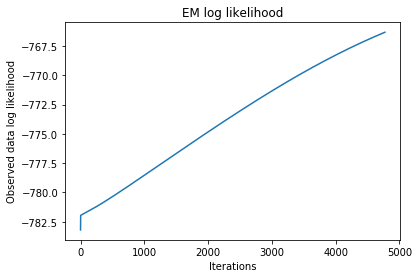

In [133]:
time = [i for i in range(len(em.obs_log_lik))]
plt.plot(time, em.obs_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [134]:
def mapd(actual, pred):
    return np.average(np.abs((actual-pred)/actual)) * 100

print('estimated A: {}'.format(em.A))
print('true A: {}'.format(model.A))
print('mean absolute percentage difference of A: {}'.format(mapd(model.A, em.A)))
print('estimated b: {}'.format(em.b))
print('true b: {}'.format(model.b))
print('mean absolute percentage difference of b: {}'.format(mapd(model.b, em.b)))
print('estimated initial state mean: {}'.format(em.init_z))
print('true initial state mean: {}'.format(model.init_z))
print('mean absolute percentage difference of initial state mean: {}'.format(mapd(model.init_z, em.init_z)))
print('estimated sigma_0: {}'.format(em.sigma_0))
print('true sigma_0: {}'.format(model.noise_0))
print('mean absolute percentage difference of initial state variance: {}'.format(mapd(model.noise_0, em.sigma_0)))
print('estimated sigma_1: {}'.format(em.sigma_1))
print('true sigma_1: {}'.format(model.noise_1))
print('mean absolute percentage difference of transition variance: {}'.format(mapd(model.noise_1, em.sigma_1)))
print('estimated sigma_2: {}'.format(em.sigma_2))
print('true sigma_2: {}'.format(model.noise_2))
print('mean absolute percentage difference of observation variance: {}'.format(mapd(model.noise_2, em.sigma_2)))
print('estimated ratio: {}'.format(em.sigma_1/em.sigma_2))
print('true ratio: {}'.format(model.noise_1/model.noise_2))
print('intercept: {}'.format(em.intercept))

estimated A: [[0]]
true A: [[0]]
mean absolute percentage difference of A: nan
estimated b: [15.05577187]
true b: [10]
mean absolute percentage difference of b: 50.557718698464285
estimated initial state mean: 4.251252236244024
true initial state mean: 6
mean absolute percentage difference of initial state mean: 29.145796062599594
estimated sigma_0: 10.950515008772397
true sigma_0: 10
mean absolute percentage difference of initial state variance: 9.505150087723973
estimated sigma_1: 0.8884673893323782
true sigma_1: 1
mean absolute percentage difference of transition variance: 11.153261066762177
estimated sigma_2: 0.05008032188134094
true sigma_2: 0.01
mean absolute percentage difference of observation variance: 400.8032188134094
estimated ratio: 17.740848220534417
true ratio: 100.0
intercept: [-0.42870207]


/home/bear/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: x and y must have same first dimension, but have shapes (0,) and (66,)

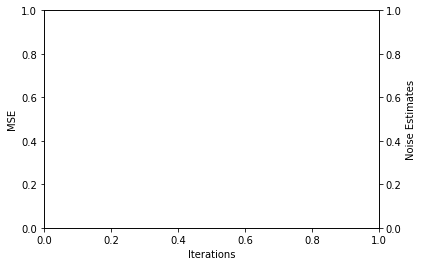

In [8]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
#ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]+1], label='sigma 0')
ax2.axhline(y=model.noise_2, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Coefficient Estimates')
color = ['m', 'y']
for i in range(em.A.shape[1]):
    ax2.plot(time, em.params[i], label='Coefficient A {}'.format(i+1))
    ax2.axhline(y=model.A[0, i], linestyle=':', label='true value coeffient A {}'.format(i+1), color=color[i])
for i in range(em.A.shape[1], em.A.shape[1]+em.b.shape[0]):
    ax2.plot(time, em.params[i], label='Coeffient b {}'.format(i+1-em.A.shape[1]))
    ax2.axhline(y=model.b[i-em.A.shape[1]], linestyle=':', label='true value coeffient b')
#for i in range(em.A.shape[1]+em.b.shape[0], len(em.params.keys())):
#    plt.plot(time,)
plt.legend()
plt.show()

In [ ]:
for n in range(10):
    plot(em, n, time_unit=1, true_model=True, model=model, signal_name='simulation', treatment_types=['1', '2'])

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[len(em.params.keys())-1], label='sigma 2')
ax2.axhline(y=model.noise_2, color='g', linestyle=':', label='true value')
plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Noise Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]+2], label='sigma 1')
ax2.axhline(y=model.noise_1, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
time = [i for i in range(len(em.mse))]
ax1.plot(time, em.mse, label='MSE', color='r')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MSE')

ax2 = ax1.twinx()
ax2.set_ylabel('Initial state mean Estimates')
ax2.plot(time, em.params[em.A.shape[1]+em.b.shape[0]], label='initial state mean')
ax2.axhline(y=model.init_z, color='g', linestyle=':', label='true value')

plt.legend()
plt.show()

In [ ]:
em.obs_log_lik

In [ ]:
time = [i for i in range(len(em.expected_log_lik))]
plt.plot(time, em.expected_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Expected data log likelihood')
plt.title('EM expected log likelihood')
plt.show()

In [ ]:
%%capture
# to debug loglik
for i in range(0):
    model = Model(20, 1, 0.3)
    model.run_simulation()
    em = EM(model.y, model.X, model.c, model.A.shape[0], 0, train_pct = 1, single_effect=False)
    num_iter = em.run_EM(5000)
    #loglik_increase = all([em.expected_log_lik[j] <= em.expected_log_lik[j+1] for j in range(len(em.expected_log_lik)-1)])
    loglik_increase = all([em.obs_log_lik[j] <= em.obs_log_lik[j+1] for j in range(len(em.obs_log_lik)-1)])
    if not loglik_increase:
        break

In [ ]:
i

In [ ]:
time = [i for i in range(len(em.obs_log_lik))]
plt.plot(time, em.obs_log_lik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

In [ ]:
#measurements = ma.asarray(model.y)
#measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked
measurements = ma.asarray(model.y)
measurements[:, np.where(np.isnan(model.y[0, :]))[0]] = ma.masked

In [ ]:
from pykalman import KalmanFilter
X = np.transpose(measurements)
kf = KalmanFilter(transition_matrices = 1, observation_matrices = 1, initial_state_covariance=em.init_0, initial_state_mean=em.init_state, transition_covariance=em.init_1, observation_covariance=em.init_2)
kf = kf.em(X, n_iter=num_iter, em_vars=['initial_state_mean', 'initial_state_covariance', 'transition_covariance', 'observation_covariance'])

time = [i for i in range(len(kf.loglik))]
plt.plot(time, kf.loglik)
#plt.axhline(y=log_lik_true_param, color='r')
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('pykalman log likelihood')
plt.show()

In [ ]:
all([kf.loglik[j] <= kf.loglik[j+1] for j in range(len(kf.loglik)-1)])

In [ ]:
kf.initial_state_covariance[0][0]

In [ ]:
em.sigma_0

In [ ]:
kf.initial_state_mean[0]

In [ ]:
em.init_z

In [ ]:
kf.transition_covariance[0][0]

In [ ]:
em.sigma_1

In [ ]:
kf.observation_covariance[0][0]

In [ ]:
em.sigma_2

### Last Observation Carry Forward

In [ ]:
# assume the first observation is not nan and the data array is not entirely nan
def LBCF(data):
    filled = np.zeros(data.shape)
    for n in range(data.shape[0]):
        for i, y in enumerate(data[n, :]):
            if np.isnan(y):
                filled[n, i] = filled[n, i-1]
            else:
                filled[n, i] = y
    return filled

### Notes on the current model

1. Identifying coefficients is still somewhat challenging (often off by a little), especially when the noises are larger.
2. When the coefficients are too small i.e. closer to the noise value, the model is unable to recover them.
3. The model has trouble identifying the noise values.  

sigma_filter appears to converge to a value for all t > $t_0$. This replicates the updates equations, where y represents sigma_pred, x represents kgain, z represents sigma_filter. Following iterations, z always converges to one of the roots of the polynomial z^2 + a*z -a*b.